# Logistic Regression using MNIST

---

#### Goals

1. Making blocked code with well-defined flow-based functions
2. Doing Logistic Regression on MNIST with Mini-batch Stochastic Gradient Descent

---

#### Basic Flow of Deep Learning

![Flow Image](https://monet.postech.ac.kr/~wldh/flow.png?v=3)

---

## 1. Library Importation & Device Preparation

In [2]:
# You don't need to edit this section today.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch
import torch.nn as nn

from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

MNIST.resources = [
    (
        'https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz',
        'f68b3c2dcbeaaa9fbdd348bbdeb94873'
    ), (
        'https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz',
        'd53e105ee54ea40749a09fcbcd1e9432'
    ), (
        'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz',
        '9fb629c4189551a2d022fa330f9573f3'
    ), (
        'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz',
        'ec29112dd5afa0611ce80d1b7f02629c'
    )
]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [43]:
### Put your script here ###

# Data Loader
batch_size = 32

# Model
hidden_layer = 200

# Learning
logging_dispfig = True
maximum_epoch = 25
learning_rate = 0.1

## 3. Data Load & Preprocessing

Because MNIST dataset is already well-preprocessed imageset, we will not perform any preprocessing today.

In [4]:
# Load dataset into python variable
### Put your script here ###

train_data = MNIST("./", train = True, transform=ToTensor(), target_transform=None, download=True)
train_data, valid_data = random_split(train_data, [54000, 6000])
test_data = MNIST("./", train = False, transform=ToTensor(), target_transform=None, download=True)

31.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

81.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

102.8%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


112.7%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!



/home/piai/anaconda3/envs/AIBD/lib/python3.8/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train dataset length = 54000
Valid dataset length = 6000
Test dataset length = 10000

Content of Y (Label, type=<class 'int'>) = 2
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


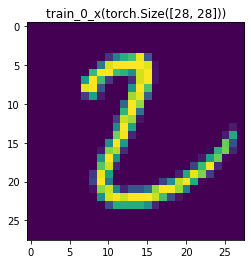

In [6]:
# Check the data

## python Tempalate Literal <f>Baisc
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')

plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x({train_0_x.squeeze().shape})')
plt.show()

In [9]:
# Create data loader

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, pin_memory=True, drop_last = True)
valid_loader = DataLoader(valid_data, batch_size =len(valid_data), shuffle = True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size = len(test_data), shuffle = True, pin_memory=True)


Idx: 0 / X.shape = torch.Size([32, 1, 28, 28]) / Y.shape = torch.Size([32]) 

Y[0:32] = tensor([4, 0, 6, 5, 2, 0, 2, 4, 0, 3, 1, 2, 4, 4, 4, 4, 0, 8, 0, 0, 8, 5, 9, 2,
        0, 8, 4, 2, 0, 4, 0, 9])


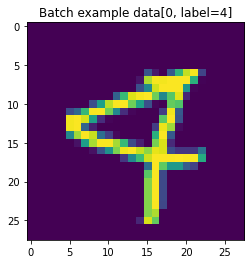

In [11]:
# Examine the data loader

train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape} \n')
print(f'Y[0:{batch_size}] = {ex_label}')

preview_index = 0
plt.figure(2)
plt.imshow(ex_data[preview_index, 0, :, :])
plt.title(f'Batch example data[{preview_index}, label={ex_label[preview_index]}]')
plt.show()

## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [12]:
# Model (1차)
def init_model():
    global net, loss_fn, optim # globar변수 사용
    net =nn.Linear(len(train_0_x.view([-1])), 10, bias=False).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = SGD(net.parameters(), lr=learning_rate)

In [48]:
# Model (2차)
def init_model():
    global net, loss_fn, optim # globar변수 사용
    net =nn.Sequential(
        nn.Linear(len(train_0_x.view([-1])), hidden_layer, bias=False), nn.ReLU(), nn.Linear(hidden_layer, 10, bias=False)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = SGD(net.parameters(), lr=learning_rate)
    nn.init.xavier_normal_(net[0].weight)
    nn.init.xavier_normal_(net[2].weight)

In [26]:
# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0
    
def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []
    last_out, last_labl = None, None
    last_grad_performed = False
    
    # mini-batch iteration
    for _data, _label in data_loader:
        data = _data.view([len(_data), -1]).to(device)
        label = _label.to(device)
        
        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial/len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in 'torch.no_grad()'
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed=True

        # 5. Save current iteration data for future use
        last_out = out.cpu().detach()
        last_label = _label
    
    if last_grad_performed:
        epoch_cnt += 1
    return np.average(iter_loss), np.average(iter_acc), last_out, last_label


def epoch_not_finished():
    # For now, let's repeat training fixed times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch


In [32]:
# Logging
# You don't need to edit this section today.
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)


    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1
  
  
def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
            + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
            + f'V_acc {last(vacc_log):<6.5f}   :🕒: {last(time_log):5.3f}s'
    log_stack.append(log_str)
    
    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')
    
        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')
    
        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')
    
        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## 5. Training Iteration

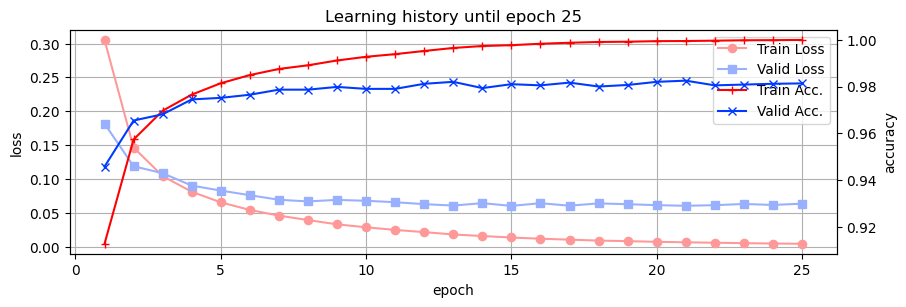

Iter:   25 >> T_loss 0.00431    T_acc 0.99987   V_loss 0.06356    V_acc 0.98133   :⏰: 5.482s
Iter:   24 >> T_loss 0.00470    T_acc 0.99978   V_loss 0.06171    V_acc 0.98117   :⏰: 5.479s
Iter:   23 >> T_loss 0.00521    T_acc 0.99972   V_loss 0.06313    V_acc 0.98083   :⏰: 5.477s
Iter:   22 >> T_loss 0.00588    T_acc 0.99956   V_loss 0.06135    V_acc 0.98050   :⏰: 5.493s
Iter:   21 >> T_loss 0.00652    T_acc 0.99941   V_loss 0.06043    V_acc 0.98250   :⏰: 5.464s
Iter:   20 >> T_loss 0.00720    T_acc 0.99935   V_loss 0.06137    V_acc 0.98200   :⏰: 5.441s
Iter:   19 >> T_loss 0.00821    T_acc 0.99911   V_loss 0.06278    V_acc 0.98067   :⏰: 5.428s
Iter:   18 >> T_loss 0.00903    T_acc 0.99900   V_loss 0.06399    V_acc 0.98000   :⏰: 5.394s
Iter:   17 >> T_loss 0.01041    T_acc 0.99867   V_loss 0.06058    V_acc 0.98167   :⏰: 5.401s
Iter:   16 >> T_loss 0.01178    T_acc 0.99824   V_loss 0.06425    V_acc 0.98050   :⏰: 5.486s
Iter:   15 >> T_loss 0.01360    T_acc 0.99763   V_loss 0.06031    V_ac

In [49]:
# Training Initialization
init_model()
init_epoch()
init_log()

while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
print('\n Training completed!')    
    

## 6. Result Analysis

In this section, we will calculate accuracy and confusion matrix for test dataset.

In [35]:
# Accuracy for test dataset
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print(f'Test accuracy = {test_acc}\n Test loss = {test_loss}')

Test accuracy = 0.9228000044822693
 Test loss = 0.2736644744873047


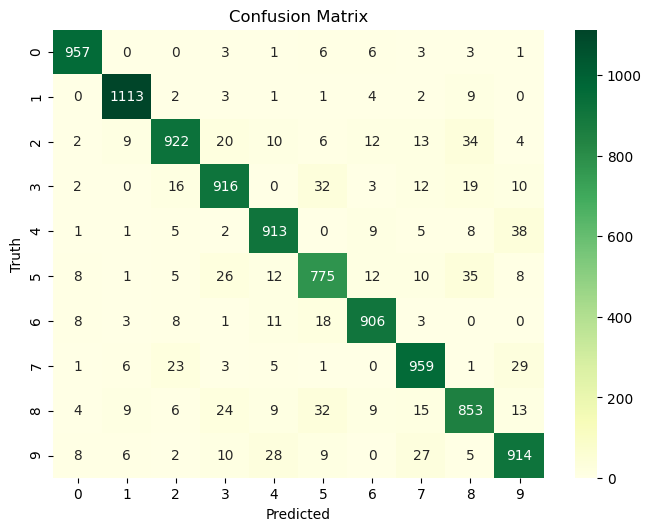

In [38]:
# Confusion matrix
our_cmatrix = confusion_matrix(test_label, test_out)
plt.figure(figsize=(8, 6), dpi=99)

sns.heatmap(our_cmatrix, annot=True, fmt='g', cmap='YlGn').set(xlabel='Predicted', ylabel='Truth')
plt.title('Confusion Matrix')
plt.show()

## 7. Saving Model

Are you satisfied with your model? Then save it!

In [ ]:
torch.save(net.state_dict(), './model.pkl')

If you want to load your model, enter below.

In [ ]:
net = torch.load('./model.pkl')